In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import numpy as np
import copy
from model.HashedMLP import HashedMLP
import h5py
Image.MAX_IMAGE_PIXELS = 933120000
from sklearn.preprocessing import StandardScaler,QuantileTransformer

%matplotlib inline

In [292]:
n_input = 2
n_output = 3
n_hidden = 64
n_layers = 2
n_entries = 2**20
n_feature = 2
base_grids = torch.tensor([16,16]).cuda()
n_level = 15
n_factor = 1.5
n_auxin = 0
act = nn.ReLU()
model = HashedMLP(n_input, n_output, n_hidden, n_layers, n_entries, n_feature, base_grids, n_level, n_factor, n_auxin, act)
model.load_state_dict(torch.load('../checkpoint/eso1625a_compression_best.pth'))
model.cuda()
model.eval()

HashedMLP(
  (interpolator): ModuleList(
    (0): HashedInterpolator()
    (1): HashedInterpolator()
    (2): HashedInterpolator()
    (3): HashedInterpolator()
    (4): HashedInterpolator()
    (5): HashedInterpolator()
    (6): HashedInterpolator()
    (7): HashedInterpolator()
    (8): HashedInterpolator()
    (9): HashedInterpolator()
    (10): HashedInterpolator()
    (11): HashedInterpolator()
    (12): HashedInterpolator()
    (13): HashedInterpolator()
    (14): HashedInterpolator()
  )
  (MLP): MLP(
    (output): Sequential(
      (0): Linear(in_features=30, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=3, bias=True)
    )
  )
)

In [293]:
stride = 2
data = torch.tensor(np.array(Image.open('../data/eso1625a.tif'))).float()[::stride,::stride]
original_shape = data.shape
coord = torch.stack(torch.meshgrid(torch.arange(data.shape[0]),torch.arange(data.shape[1])),-1).float()
coord[...,0] = coord[...,0]/data.shape[0]
coord[...,1] = coord[...,1]/data.shape[1]
coord = torch.flatten(coord,end_dim=-2)
data = torch.flatten(data,end_dim=-2)

In [294]:
batch_size = 1000000
pred = []
for i in range(0,data.shape[0],batch_size):
    with torch.no_grad():
        output = model(coord[i:i+batch_size].cuda())
        pred.append(output.cpu().numpy())
pred = np.concatenate(pred,axis=0).reshape(original_shape).astype(int)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


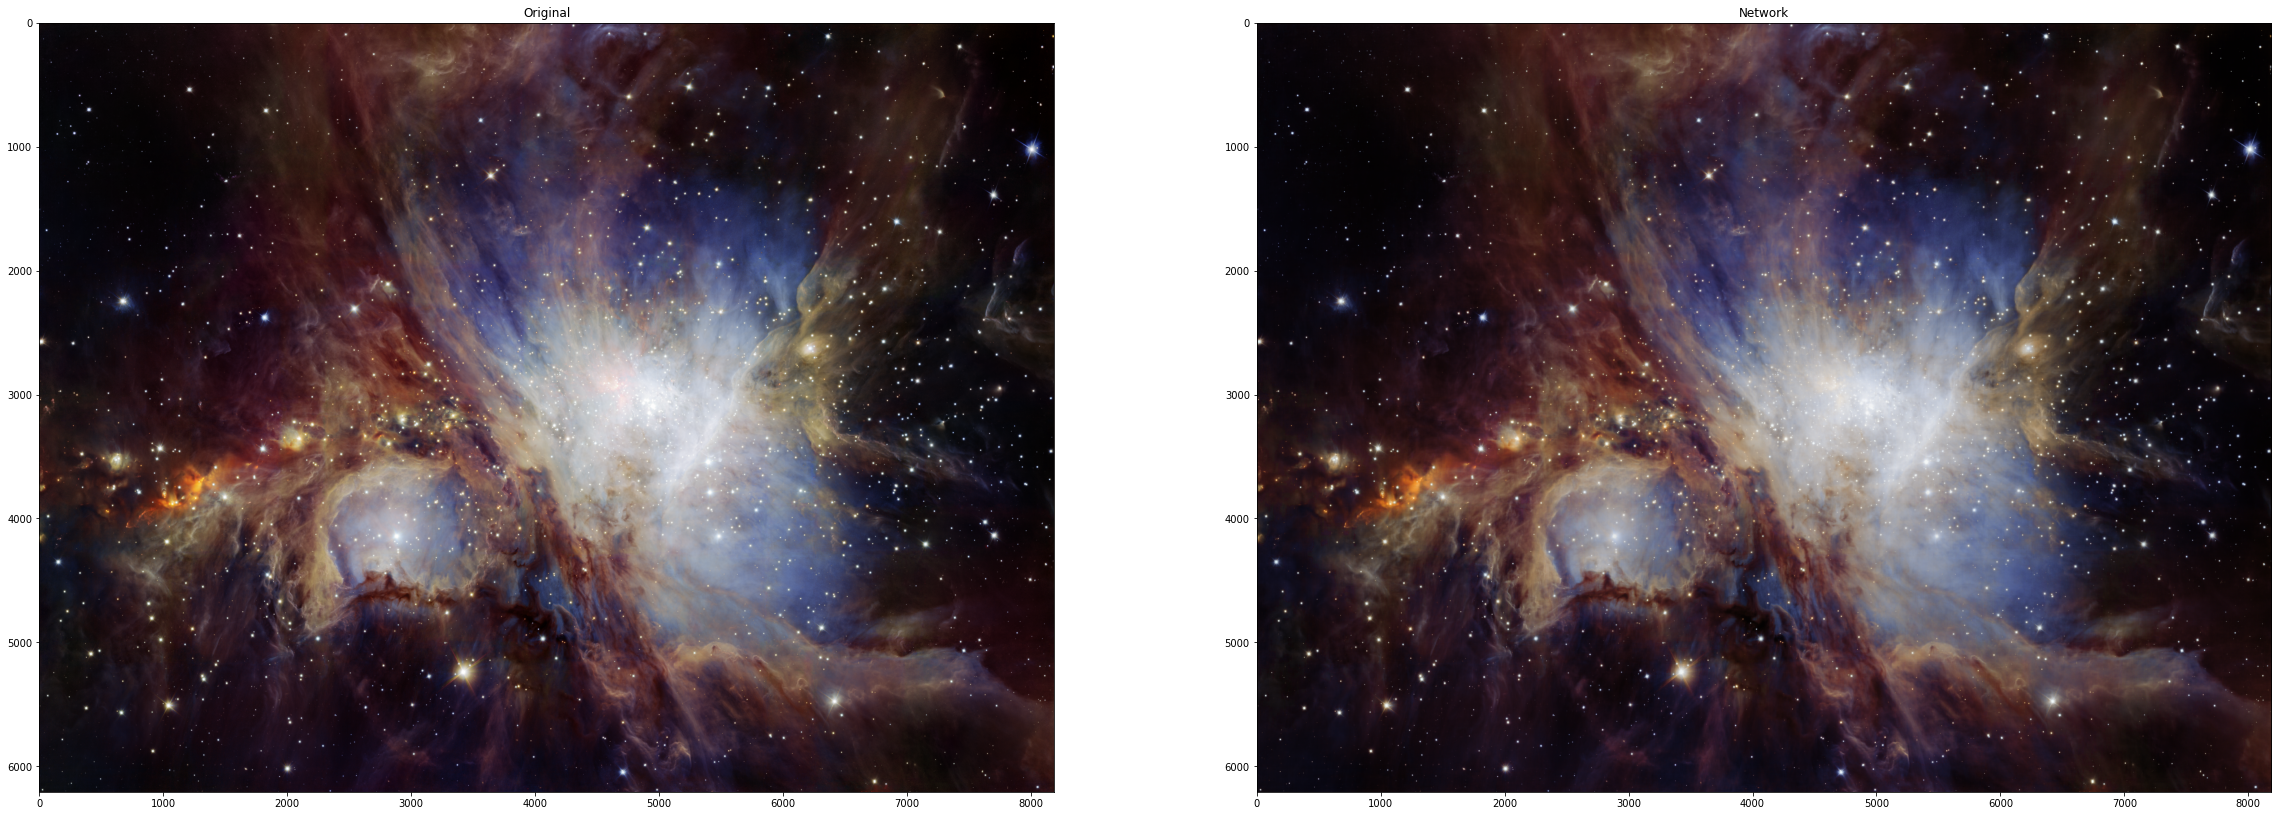

In [296]:
fig, ax = plt.subplots(1,2,figsize=(40,20))
ax[0].imshow(data.reshape(original_shape).numpy().astype(int))
ax[0].set_title('Original')
ax[1].imshow(pred)
ax[1].set_title('Network')
fig.savefig('../plots/eso1625a_compression_best.pdf',bbox_inches='tight')

In [297]:
n_input = 3
n_output = 1
n_hidden = 64
n_layers = 2
n_entries = 2**22
n_feature = 2
base_grids = torch.tensor([16,16,16]).cuda()
n_level = 8
n_factor = 1.5
n_auxin = 0
act = nn.ReLU()
model = HashedMLP(n_input, n_output, n_hidden, n_layers, n_entries, n_feature, base_grids, n_level, n_factor, n_auxin, act)
model.load_state_dict(torch.load('../checkpoint/camel_compression_512_best.pth'))
model.cuda()
model.eval()

HashedMLP(
  (interpolator): ModuleList(
    (0): HashedInterpolator()
    (1): HashedInterpolator()
    (2): HashedInterpolator()
    (3): HashedInterpolator()
    (4): HashedInterpolator()
    (5): HashedInterpolator()
    (6): HashedInterpolator()
    (7): HashedInterpolator()
  )
  (MLP): MLP(
    (output): Sequential(
      (0): Linear(in_features=16, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [298]:
stride = 2
data = np.load('../data/camel_compression_512.npz')['mass'][::stride,::stride,::stride][...,None]
data = torch.tensor(data).float()

original_shape = data.shape
coord = torch.stack(torch.meshgrid(torch.arange(data.shape[0]),torch.arange(data.shape[1]),torch.arange(data.shape[2])),-1).float()
coord[...,0] = coord[...,0]/data.shape[0]
coord[...,1] = coord[...,1]/data.shape[1]
coord[...,2] = coord[...,2]/data.shape[2]
coord = torch.flatten(coord,end_dim=-2)
data = torch.flatten(data,end_dim=-2)

data = torch.log10(1+data)
# scaler = StandardScaler()
# scaler = QuantileTransformer()
# scaler.fit(data.detach().cpu().numpy())
# data = torch.tensor(scaler.transform(data.detach().cpu().numpy())).float()

In [299]:
batch_size = 100000
pred = []
for i in range(0,data.shape[0],batch_size):
    with torch.no_grad():
        output = model(coord[i:i+batch_size].cuda())
        pred.append(output.cpu().numpy())
pred = np.concatenate(pred,axis=0).reshape(original_shape)


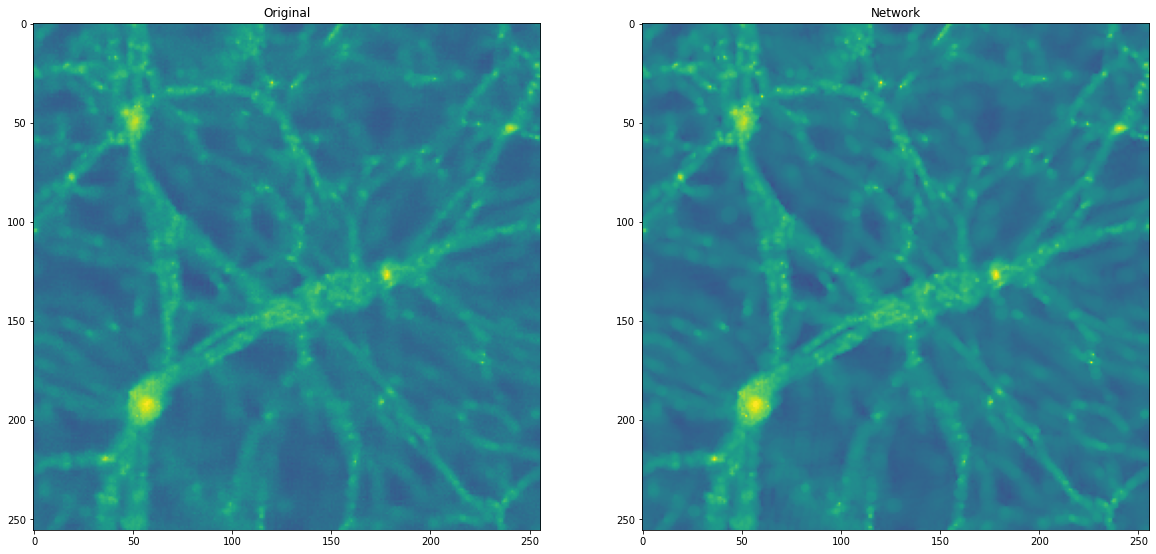

In [300]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(pred[0],vmin=data.min(),vmax=data.max()*0.8)
ax[0].set_title('Original')
ax[1].imshow(data.reshape(original_shape).numpy()[0],vmin=data.min(),vmax=data.max()*0.8)
ax[1].set_title('Network')
fig.savefig('../plots/camels_compression_best.pdf',bbox_inches='tight')

In [122]:
n_input = 3
n_output = 1
n_hidden = 64
n_layers = 2
n_entries = 2**18
n_feature = 2
base_grids = torch.tensor([16,16,16]).cuda()
n_level = 8
n_factor = 1.5
n_auxin = 0
act = nn.ReLU()
model = HashedMLP(n_input, n_output, n_hidden, n_layers, n_entries, n_feature, base_grids, n_level, n_factor, n_auxin, act)
model.load_state_dict(torch.load('../checkpoint/Athena_mixing_layer_256_best.pth'))
model.cuda()
model.eval()

HashedMLP(
  (interpolator): ModuleList(
    (0): HashedInterpolator()
    (1): HashedInterpolator()
    (2): HashedInterpolator()
    (3): HashedInterpolator()
    (4): HashedInterpolator()
    (5): HashedInterpolator()
  )
  (MLP): MLP(
    (output): Sequential(
      (0): Linear(in_features=12, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [123]:
stride = 2
data = h5py.File("/mnt/ceph/users/wwong/Simulations/AstroSimChallenge/Athena/mixing_layer.hdf5",'r')['rho'][::stride,::stride,::stride][...,None]
data = torch.tensor(data).float()

original_shape = data.shape
coord = torch.stack(torch.meshgrid(torch.arange(data.shape[0]),torch.arange(data.shape[1]),torch.arange(data.shape[2])),-1).float()
coord[...,0] = coord[...,0]/data.shape[0]
coord[...,1] = coord[...,1]/data.shape[1]
coord[...,2] = coord[...,2]/data.shape[2]
coord = torch.flatten(coord,end_dim=-2)
data = torch.flatten(data,end_dim=-2)

In [124]:
batch_size = 100000
pred = []
for i in range(0,data.shape[0],batch_size):
    with torch.no_grad():
        output = model(coord[i:i+batch_size].cuda())
        pred.append(output.cpu().numpy())
pred = np.concatenate(pred,axis=0).reshape(original_shape)

Text(0.5, 1.0, 'Network')

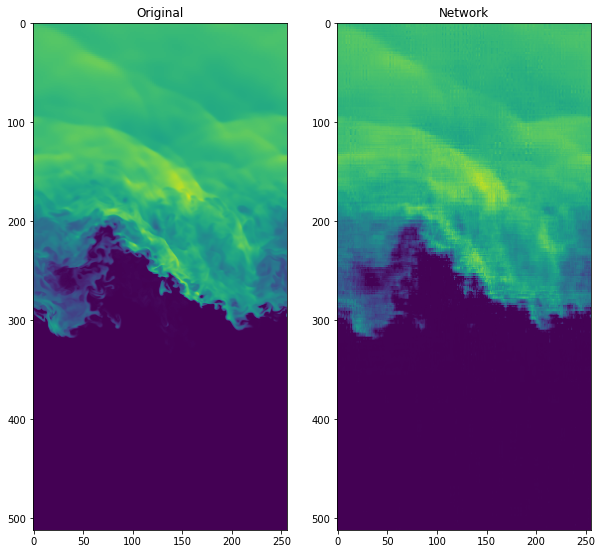

In [125]:
fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(data.reshape(original_shape).numpy()[:,0],vmin=data.min(),vmax=data.max()*0.8)
ax[0].set_title('Original')
ax[1].imshow(pred[:,0],vmin=data.min(),vmax=data.max()*0.8)
ax[1].set_title('Network')
#fig.savefig('../plots/athena_mixingLayer_compression_best.pdf',bbox_inches='tight')

In [108]:
n_input = 3
n_output = 1
n_hidden = 64
n_layers = 2
n_entries = 2**18
n_feature = 2
base_grids = torch.tensor([16,16,16]).cuda()
n_level = 6
n_factor = 1.5
n_auxin = 0
act = nn.ReLU()
model = HashedMLP(n_input, n_output, n_hidden, n_layers, n_entries, n_feature, base_grids, n_level, n_factor, n_auxin, act)
model.load_state_dict(torch.load('../checkpoint/Athena_turbulence_512_best.pth'))
model.cuda()
model.eval()

HashedMLP(
  (interpolator): ModuleList(
    (0): HashedInterpolator()
    (1): HashedInterpolator()
    (2): HashedInterpolator()
    (3): HashedInterpolator()
    (4): HashedInterpolator()
    (5): HashedInterpolator()
  )
  (MLP): MLP(
    (output): Sequential(
      (0): Linear(in_features=12, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [109]:
stride = 8
data = h5py.File("/mnt/ceph/users/wwong/Simulations/AstroSimChallenge/Athena/plasmoid_static.hdf5",'r')['rho'][::stride,::stride,::stride][...,None]
data = torch.tensor(data).float()

original_shape = data.shape
coord = torch.stack(torch.meshgrid(torch.arange(data.shape[0]),torch.arange(data.shape[1]),torch.arange(data.shape[2])),-1).float()
coord[...,0] = coord[...,0]/data.shape[0]
coord[...,1] = coord[...,1]/data.shape[1]
coord[...,2] = coord[...,2]/data.shape[2]
coord = torch.flatten(coord,end_dim=-2)
data = torch.flatten(data,end_dim=-2)

In [111]:
batch_size = 100000
pred = []
for i in range(0,data.shape[0],batch_size):
    with torch.no_grad():
        output = model(coord[i:i+batch_size].cuda())
        pred.append(output.cpu().numpy())
pred = np.concatenate(pred,axis=0).reshape(original_shape)

/tmp/ipykernel_3516855/3827636310.py:4: RuntimeWarning: invalid value encountered in log10
  ax[1].imshow(np.log10(1+pred[:,128]),vmin=np.log10(1+data.min()),vmax=np.log10(1+data.max())*0.8)


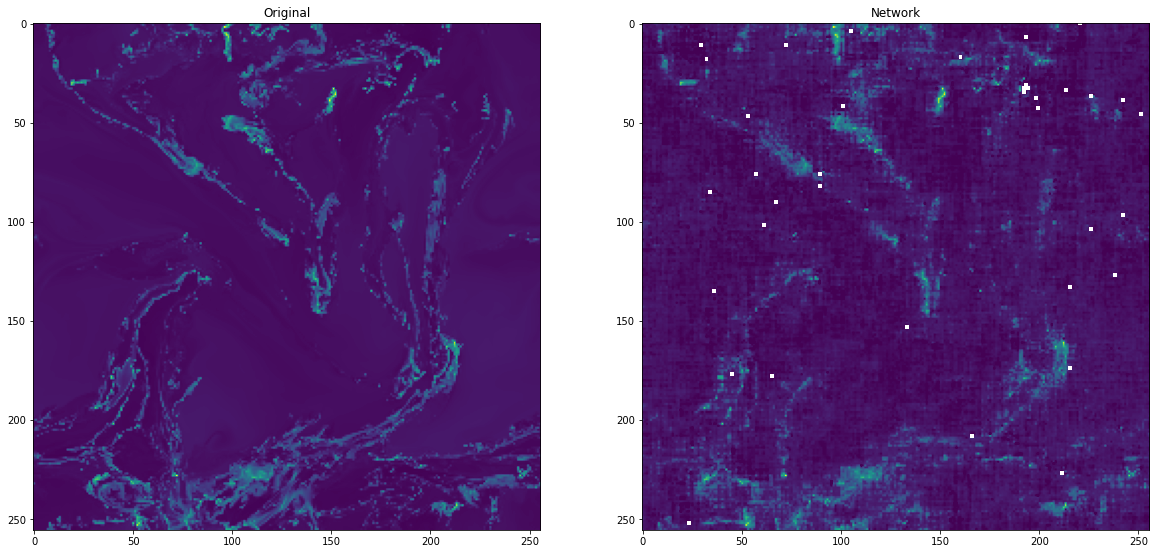

In [117]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(np.log10(1+data.reshape(original_shape).numpy()[:,128]),vmin=np.log10(1+data.min()),vmax=np.log10(1+data.max())*0.8)
ax[0].set_title('Original')
ax[1].imshow(np.log10(1+pred[:,128]),vmin=np.log10(1+data.min()),vmax=np.log10(1+data.max())*0.8)
ax[1].set_title('Network')
fig.savefig('../plots/athena_turblance_compression_best.pdf',bbox_inches='tight')

In [115]:
data.max()

tensor(1838.8813)